<a href="https://colab.research.google.com/github/SheryllD/diabetic_retinopathy_ml/blob/main/Diabetic_Retinopathy_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New section

## 1. Setup and Imports

In [ ]:
# Install Kaggle API
!pip install Kaggle

### Libraries

In [ ]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import cv2
from PIL import Image

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')
print("Necessary modules have been imported")

## 2. Mount Drive and Set up Kaggle

In [2]:
from google.colab import drive
drive.mount('/content/drive')
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/Keys/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d tanlikesmath/diabetic-retinopathy-resized

Mounted at /content/drive
Dataset URL: https://www.kaggle.com/datasets/tanlikesmath/diabetic-retinopathy-resized
License(s): unknown
^C


## 3. Loading Dataset

In [4]:
# Importing kaggle
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tanlikesmath/diabetic-retinopathy-resized")

print("Path to dataset files:", path)

100%|██████████| 7.25G/7.25G [01:20<00:00, 97.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/tanlikesmath/diabetic-retinopathy-resized/versions/7


### Dataset Paths

In [7]:
# Reviewing the paths
print("Downloaded path:", path)
print("Contents of the folder:")
print(os.listdir(path))

Downloaded path: /root/.cache/kagglehub/datasets/tanlikesmath/diabetic-retinopathy-resized/versions/7
Contents of the folder:
['trainLabels_cropped.csv', 'resized_train', 'trainLabels.csv', 'resized_train_cropped']


In [9]:
base_path = "/root/.cache/kagglehub/datasets/tanlikesmath/diabetic-retinopathy-resized/versions/7"
print("Contents:", os.listdir(base_path))

# base_path = "/kaggle/input/diabetic-retinopathy-resized"
# print("Contents:", os.listdir(base_path))

Contents: ['trainLabels_cropped.csv', 'resized_train', 'trainLabels.csv', 'resized_train_cropped']


### Load and Clean CSV

In [10]:
# I am using the cropped images to reduce the noise

df_images = os.path.join(base_path, "resized_train_cropped", "resized_train_cropped")
labels = os.path.join(base_path, "trainLabels_cropped.csv")

print("Images folder: ", df_images)
print("Labels file:", labels)

Images folder:  /root/.cache/kagglehub/datasets/tanlikesmath/diabetic-retinopathy-resized/versions/7/resized_train_cropped/resized_train_cropped
Labels file: /root/.cache/kagglehub/datasets/tanlikesmath/diabetic-retinopathy-resized/versions/7/trainLabels_cropped.csv


In [11]:
# Loading the CSV
df_labels = pd.read_csv(labels, header=0)
print(df_labels.head())

   Unnamed: 0.1  Unnamed: 0     image  level
0             0           0   10_left      0
1             1           1  10_right      0
2             2           2   13_left      0
3             3           3  13_right      0
4             4           4   15_left      1


## 5. EDA (Exploratory Data Analysis) & Binary Labeling

In [12]:
#Number values
images_files = os.listdir(df_images)

print(f"Number of images:", {len(images_files)})
print(f"Number of inputs (labels):", {len(df_labels)})

Number of images: {35108}
Number of inputs (labels): {35108}


In [13]:
# Reviewing the basic info
df_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35108 entries, 0 to 35107
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0.1  35108 non-null  int64 
 1   Unnamed: 0    35108 non-null  int64 
 2   image         35108 non-null  object
 3   level         35108 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.1+ MB


In [14]:
# Droppng the unnamed:0 columns to minimise noise
df_labels = df_labels.drop(columns=["Unnamed: 0.1", "Unnamed: 0"])
print(df_labels.head(1))

     image  level
0  10_left      0


In [15]:
df_labels.describe()

,level
count,35108.000000
mean,0.525863
std,0.970372
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,4.000000


In [16]:
# How many missing?
df_labels.isna().sum()

,0
image,0
level,0


In [17]:
# How many duplicated?
df_labels.duplicated().sum()

np.int64(0)

In [18]:
df_num_columns = df_labels.select_dtypes(include="number")
df_num_columns

,level
0,0
1,0
2,0
3,0
4,1
...,...
35103,0
35104,0
35105,0
35106,0


In [19]:
# How many classes?
print("Unique labels", df_labels['level'].unique())
print("Class distribution:\n", df_labels["level"].value_counts())
print("Total:", df_labels.value_counts())

Unique labels [0 1 2 4 3]
Class distribution:
 level
0    25802
2     5288
1     2438
3      872
4      708
Name: count, dtype: int64
Total: image        level
99_right     3        1
10003_left   0        1
10003_right  0        1
10007_left   0        1
9980_right   0        1
                     ..
10010_left   0        1
1000_right   0        1
1000_left    0        1
10009_right  0        1
10009_left   0        1
Name: count, Length: 35108, dtype: int64


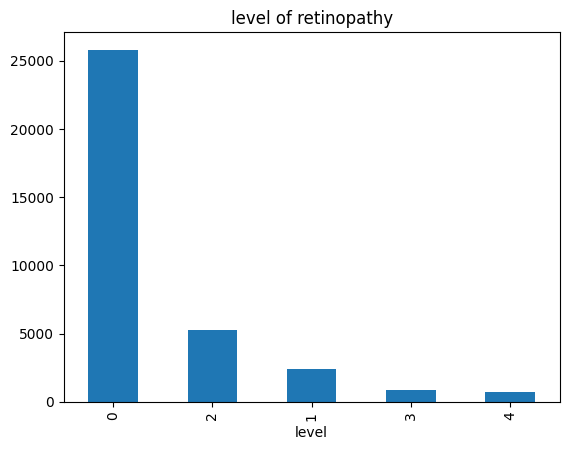

In [20]:
df_labels["level"].value_counts().plot(kind="bar")
plt.title("level of retinopathy")
plt.ylabel("")
plt.show()

0 → no DR
1 → mild
2 → moderate
3 → severe
4 → proliferative

I can see that the data is very imbalanced.

The data is very inbalanced. So the decision is to group 1, 2, 3, 4, together as 0: 'N0 DR',  1: 'Yes DR'.

Solution:
- Random under-sampling is useful but blunt.
- Using moderate under-sampling + augmentation + class_weight is the gold standard.

This ensures you don’t accidentally lose critical healthy examples.

In [21]:
print(df_labels.columns)

Index(['image', 'level'], dtype='object')


### Reviewing the **images**

In [22]:
# df_images = pd.read_csv(df_images)
# print(df_labels.head())

# Confirming folder variable
print("Images folder path:", df_images)
print("Example files inside:", os.listdir(df_images)[:5])

Images folder path: /root/.cache/kagglehub/datasets/tanlikesmath/diabetic-retinopathy-resized/versions/7/resized_train_cropped/resized_train_cropped
Example files inside: ['36286_left.jpeg', '31889_right.jpeg', '24328_left.jpeg', '17042_right.jpeg', '10042_left.jpeg']


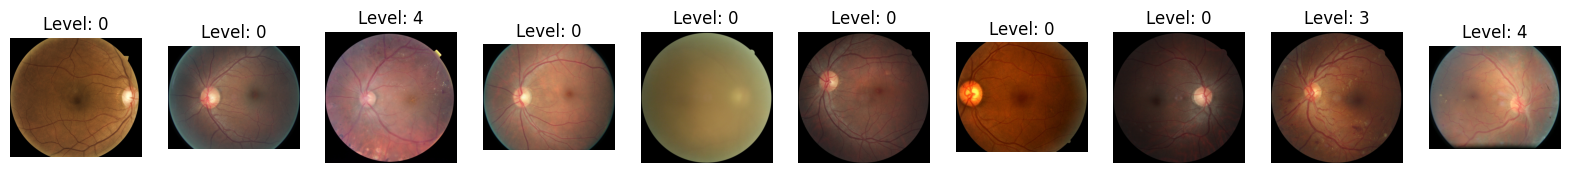

In [23]:
# picking random images
sample = df_labels.sample(10, random_state=42)

# plotting 10 random samples side by side for better overview
fig, axes = plt.subplots(1, 10, figsize=(20, 5))

for ax, (_, row) in zip(axes, sample.iterrows()):
    img_path = os.path.join(df_images, row['image'] + '.jpeg')
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(f"Level: {row['level']}")
    ax.axis('off')
plt.show()

# for idx, row in sample.iterrows():
#   img_path = os.path.join(df_images, row['image'] + '.jpeg')
#   img = Image.open(img_path)
#   plt.imshow(img)
#   plt.title(f"Label: {row['level']}")
#   plt.axis("off")
#   plt.show()

In [ ]:
# # resizing the images

# image_size = 224
# batch_size = 32
# num_classes = df_labels['level'].unique()

# print(f"Image size: {image_size}x{image_size}")
# print(f"Number of classes: {num_classes}")

### Joining the labels with the path of images

In [24]:
# Adding image path to the label Dataframe, this is the full path
df_labels["path"] = df_labels["image"].apply(lambda x: os.path.join(df_images, x + ".jpeg"))

# I am only keeping the rows if they actually exist in the folder
df_labels = df_labels[df_labels['path'].apply(os.path.exists)].copy()

# Reviewing
print("Rows with valid filles:", len(df_labels))

Rows with valid filles: 35108


Now that we got 35108 back, we can see that we haven't lost any images or values.

### Binary Classification

In [25]:
# Adding Binary column by grouping 1, 2, 3, 4 together as 1 'Has DR', 0 as 'No DR'.
df_labels['binary_level'] = df_labels['level'].apply(lambda x: 0 if x ==0 else 1)
print(df_labels[['level', 'binary_level']].head())

   level  binary_level
0      0             0
1      0             0
2      0             0
3      0             0
4      1             1


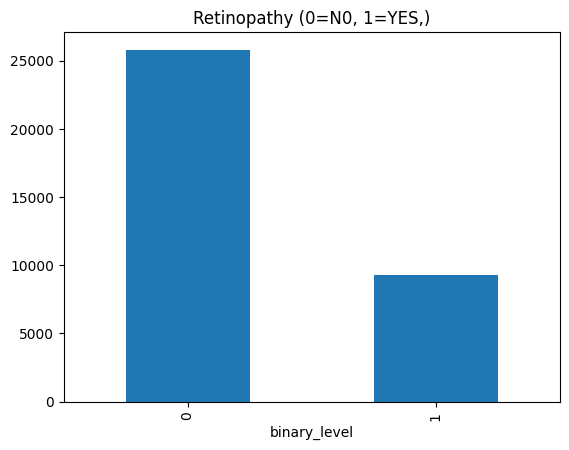

In [26]:
# Plotting
df_labels["binary_level"].value_counts().plot(kind="bar")
plt.title("Retinopathy (0=N0, 1=YES,)")
plt.ylabel("")
plt.show()

In [27]:
print(df_labels.head(10))
# print(df_labels.columns)

      image  level                                               path  \
0   10_left      0  /root/.cache/kagglehub/datasets/tanlikesmath/d...   
1  10_right      0  /root/.cache/kagglehub/datasets/tanlikesmath/d...   
2   13_left      0  /root/.cache/kagglehub/datasets/tanlikesmath/d...   
3  13_right      0  /root/.cache/kagglehub/datasets/tanlikesmath/d...   
4   15_left      1  /root/.cache/kagglehub/datasets/tanlikesmath/d...   
5  15_right      2  /root/.cache/kagglehub/datasets/tanlikesmath/d...   
6   16_left      4  /root/.cache/kagglehub/datasets/tanlikesmath/d...   
7  16_right      4  /root/.cache/kagglehub/datasets/tanlikesmath/d...   
8   17_left      0  /root/.cache/kagglehub/datasets/tanlikesmath/d...   
9  17_right      1  /root/.cache/kagglehub/datasets/tanlikesmath/d...   

   binary_level  
0             0  
1             0  
2             0  
3             0  
4             1  
5             1  
6             1  
7             1  
8             0  
9             1 

## 6. Balance Dataset

### Moderate Undersampling
I am going to moderately undersample the data.

In [28]:
# Keep 2:1 (Moderate)
df_healthy = df_labels[df_labels['binary_level'] == 0]
df_dr = df_labels[df_labels['binary_level'] == 1]

desired_healthy = 2 * len(df_dr)
df_healthy_under = df_healthy.sample(desired_healthy, random_state=42)

balanced_labels = pd.concat([df_healthy_under, df_dr]).sample(frac=1, random_state=42).reset_index(drop=True)

balanced_labels['binary_level'].value_counts()

,count
binary_level,
0,18612
1,9306


I used moderate undersampling to keep the healthy class at twice the size of the DR-positive class, preserving useful healthy variation while reducing imbalance.

In [29]:
# Reviewing Tensorflow version
print(tf.__version__)

2.18.0


In [30]:
# Calculate the class_weight

classes = np.unique(balanced_labels['binary_level'])
weights = compute_class_weight(
    class_weight = 'balanced',
    classes = classes,
    y=balanced_labels['binary_level']
)
class_weight = dict(zip(classes, weights))
print(class_weight)

{np.int64(0): np.float64(0.75), np.int64(1): np.float64(1.5)}


np.int64(0): np.float64(0.75) --> healthy, gets weight 0.75
np.int64(1): np.float64(1.5) --> gets weight 1.5

- So if the model classifies a DR image --> the loss is multipliied by 1.5, which makes it more costly.
- If it misclassifies a healthy image --> loss is multiplied by 0.75, which is less costly.
In termsL It tells the model to pay extra attention to correctly detecting the DR.

For further developing during the training, pass:
- class_weight = {0: 0.75, 1: 1.5}


## 7. Splitting into train and validation sets

In [31]:
# Splitting it into 80% training and 20% validation (stratify to keep label balance)
df_train, df_val = train_test_split(balanced_labels, test_size=0.2, stratify = balanced_labels['binary_level'], random_state=42)

# Checking train dataframe
print("Train:")
print(df_train['binary_level'].value_counts())

# Checking for valudation
print("\nValidation:")
print(df_val['binary_level'].value_counts())

Train:
binary_level
0    14889
1     7445
Name: count, dtype: int64

Validation:
binary_level
0    3723
1    1861
Name: count, dtype: int64


In [32]:
df_train['binary_level'] = df_train['binary_level'].astype(str)
df_val['binary_level'] = df_val['binary_level'].astype(str)

## 8. Image Generators
Image generators for comparison and use.

#### Defining the generators

In [33]:
# Training with augementation

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    zoom_range = 0.2,
    brightness_range = [0.7, 1.3],
    horizontal_flip =True
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [34]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe = df_train,
    directory = "",
    x_col ='path',
    y_col ='binary_level',
    target_size = (224, 224),
    batch_size = 32,
    class_mode ='binary',
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe = df_val,
    directory = None,
    x_col = 'path',
    y_col = 'binary_level',
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'binary',
    shuffle = False
)

Found 22334 validated image filenames belonging to 2 classes.
Found 5584 validated image filenames belonging to 2 classes.


What I did so far:

1. Cleaned and prepared the dataset
- dropped extra columns
- verified I have 35108 valid image-label pairs
- created a binary label: 0 = No DR, 1 = Has DR

2. Used modeerate undersampling:
- reduced the healthy class to twice the size of DR (2:1)
- final count = healthy: 18.612,  DR: 9.306, Total: 27.918

3. Calculated class weights:
- {0: 0.75, 1: 1.5}
- Model willpenalises DR mistakes more than healthy mistakes.

4. Split into train/validation with stratify
- 80% train: Healthy: 14,889, DR: 7,445
- 20% validation: Healthy: 3,723, DR: 1,861

5. Converted labels to strings
- requrement by ImageDataGenerator

6. Defined Generators:
- train: uses augementations + rescaling
- validation: only rescaling
- Finding exat right number of images

Found 22334 validated image filenames belonging to 2 classes.

Found 5584 validated image filenames belonging to 2 classes.

This matches the split.
- 14,889 + 7,445 = 22,334 (train)
- 3,723 + 1,861 = 5,584 (validation)


Next step: Build and train the model
1. EfficientNetB0 block + compile + train (with class_weight)?
2. Also the custom CNN version side-by-side?
3. Or only EfficientNet for now, one clean block?

## 9. Tf.data Pipeline

In [35]:
# Turning the splits into tf.data.Dataset

# Parsing function
def parse_image(filename, label):
  image = tf.io.read_file(filename)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [224, 224])
  image = image / 255.0
  return image, label

batch_size = 32

### Training the dataset

In [38]:
train_ds = tf.data.Dataset.from_tensor_slices((df_train['path'].values, df_train['level'].values))
train_ds = train_ds.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(1024).batch(32).prefetch(tf.data.AUTOTUNE)

### Validation dataset

In [40]:
val_ds = tf.data.Dataset.from_tensor_slices((df_val['path'].values, df_val['level'].values))
val_ds = val_ds.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [41]:
# Inspecting 1 batch

for images, labels in train_ds.take(1):
  print(f"Images shape:", images.shape)
  print(f"Labels shape:", df_labels.shape)

Images shape: (32, 224, 224, 3)
Labels shape: (35108, 4)


## 10. Model and Training

### Computing class_weight

In [42]:
# Get unique classes
classes = np.unique(df_labels['level'])
print("Classes:", classes)

# computing weights
weights = compute_class_weight(
    class_weight = 'balanced',
    classes = classes,
    y = df_train['level']
)

# Making dictionary for Keras
class_weight = dict(zip(classes, weights))
print("Classweights:", class_weight)

Classes: [0 1 2 3 4]
Classweights: {np.int64(0): np.float64(0.3000067163677883), np.int64(1): np.float64(2.2813074565883555), np.int64(2): np.float64(1.06024210776169), np.int64(3): np.float64(6.291267605633803), np.int64(4): np.float64(7.9198581560283685)}


### Building & Compiling the model

In [43]:
# Loading the basemodel
base_model = EfficientNetB0(
    input_shape = (224, 224, 3),
    include_top = False,
    weights='imagenet'
)
base_model.trainable = False

# Building head
inputs = layers.Input(shape=(224, 224, 3))
x = base_model(inputs, training = False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(5, activation='softmax')(x)

model = models.Model(inputs, outputs)

# Compiling the model

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,055,976 (15.47 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

### Training the model

In [ ]:
# early_stop = EarlyStopping(
#     monitor = 'val_loss',
#     patience= 5,
#     restore_best_weights=True
# )

# checkpoint = ModelCheckpoint(
#     'best_model.h5',
#     monitor='val_loss',
#     save_best_only=True
# )

# history = model.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=30,
#     callbacks=[early_stop, checkpoint],
#     class_weight=class_weight
# )

### Evaluate

In [ ]:
# # Creating a plot
# plt.plot(history.history['accuracy'], label='Train acc')
# plt.plot(history.history['val_accuracy'], label='Val acc')
# plt.title("Accuracy")
# plt.legend()
# plt.show()

# plt.plot(history.history['loss'], label='Train loss')
# plt.plot(history.history['val_loss'], label='Val loss')
# plt.title.("Loss")
# plt.legend()
# plt.show()